# Задание для итоговой аттестации
Поиск похожих картинок (цветов) Необходимо: обучить и протестировать модель для поиска похожих картинок. Коллекции для поиска и обучения нужно собрать из предложенных ниже наборов данных.

# Распознавание цветов
Учитывая изображения различных видов цветов, мы должны классифицировать их в соответствии с их типом.
Перед тем как начать решение данного задания следует объяснить что такое CNN — сети, основанные на принципах работы визуальной коры человеческого мозга.

**Свёрточная нейронная сеть** (ConvNet/CNN) — это алгоритм глубокого обучения, который может принимать входное изображение, присваивать важность (изучаемые веса и смещения) аспектам или объектам изображении и отличать одно от другого. При этом изображения в сравнении с другими алгоритмами требуют гораздо меньше предварительной обработки. В примитивных методах фильтры разрабатываются вручную, но достаточно обученные сети CNN учатся применять эти фильтры/характеристики.

Архитектура CNN аналогична структуре связей нейронов в мозгу человека, учёные черпали вдохновение в организации зрительной коры головного мозга. Отдельные нейроны реагируют на стимулы только в некоторой области поля зрения, также известного как перцептивное поле. Множество перцептивных полей перекрывается, полностью покрывая поле зрения CNN.

Сверточная же нейронная сеть за счет применения специальной операции – собственно свертки – позволяет одновременно уменьшить количество хранимой в памяти информации, за счет чего лучше справляется с картинками более высокого разрешения, и выделить опорные признаки изображения, такие как ребра, контуры или грани. На следующем уровне обработки из этих ребер и граней можно распознать повторяемые фрагменты текстур, которые дальше могут сложиться в фрагменты изображения.

По сути каждый слой нейронной сети использует собственное преобразование. Если на первых слоях сеть оперирует такими понятиями как “ребра”, “грани” и т.п, то дальше используются понятия “текстура”, “части объектов”. В результате такой проработки мы можем правильно классифицировать картинку или выделить на конечном шаге искомый объект на изображении.

# Классификация изображений и сигналов с помощью нейросетей

Первой и, по сути, самой тривиальной задачей, которую научились решать с помощью нейронных сетей, стала классификация изображений. Как мы уже писали выше, большинство примеров указано именно на изображениях. Но, по сути, можно классифицировать любые сигналы.
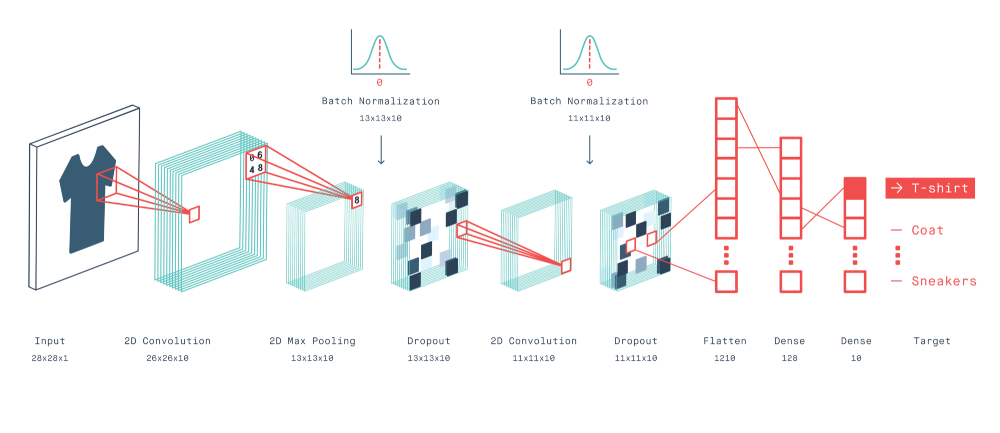

### Ипортируем используемые библиотеки

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras

import os
import random
import cv2
from tqdm import tqdm

## Загружаем наш датасет

Типы цветов в нашем датасете - 
* Daisy
* Dandelion
* Rose
* Sunflower
* Tulip

In [5]:
labels = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
IMG_SIZE = 124

Загружаем все изображения

In [6]:
def loadData(DIR):
    X = []
    Y = []
    for label in labels:
        path = os.path.join(DIR, label)
        class_num = labels.index(label)
        for img in tqdm(os.listdir(path)):
            try:
                arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_arr = cv2.resize(arr, (IMG_SIZE, IMG_SIZE))
                X.append(resized_arr)
                Y.append(class_num)
            except Exception as e:
                print(e)
    return (np.array(X), np.array(Y))

In [8]:
DIR = './flowers'
(X, Y) = loadData(DIR)

100%|██████████| 984/984 [00:02<00:00, 390.90it/s]


## Визуализация данных
Для более наглядного понимания, визуализируем данные из нашего датасета и выведем сводный график.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


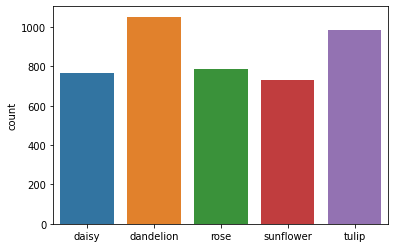

In [9]:
l = []
for img in Y:
    l.append(labels[img])
sns.countplot(l);

Сделаем случайный предварительный просмотр первых 10 изображений.


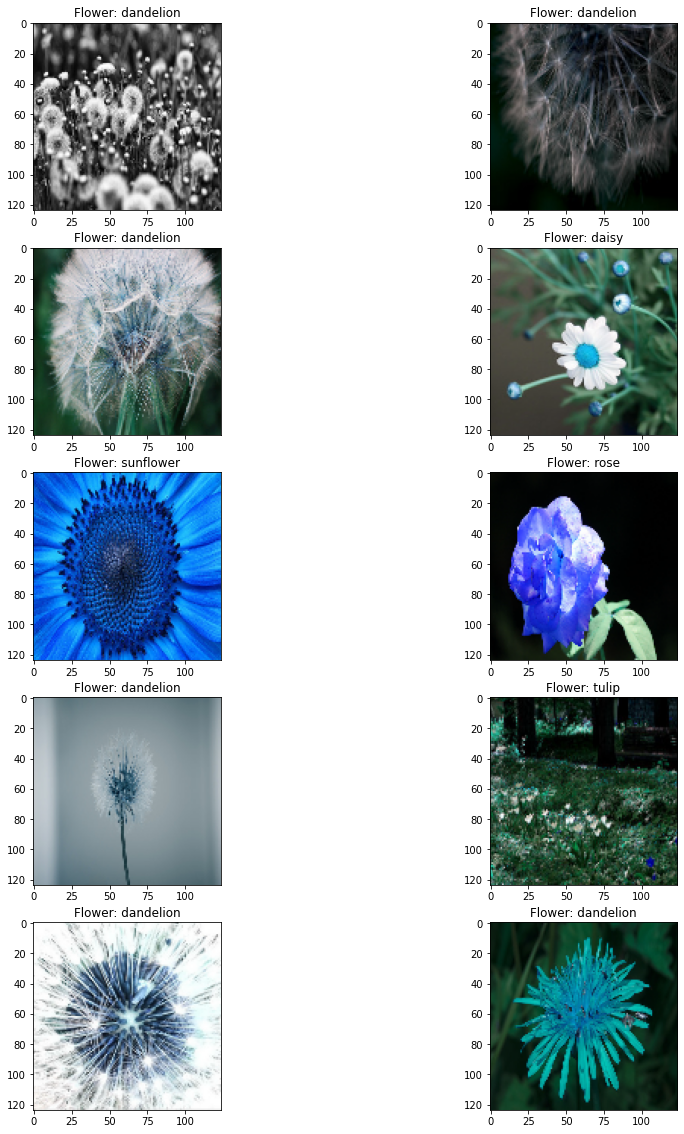

In [10]:
fig, ax = plt.subplots(5, 2)
fig.set_size_inches(15, 20)
for i in range(5):
    for j in range(2):
        l = random.randint(0, len(X))
        ax[i, j].imshow(X[l])
        ax[i, j].set_title('Flower: ' + labels[Y[l]])

## Предварительная обработка данных

## Предварительная обработка данных
Измененим форму данных с 1-D на 3-D и разделим выборку на train и test, используя библиотеку *scikit-learn*.

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X = X / 255

X = X.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y = Y.reshape(-1, 1)
Y = keras.utils.to_categorical(Y, 5)

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3)

print("X_train shape:" + str(X_train.shape))
print("Y_train shape:" + str(Y_train.shape))
print("X_test shape:" + str(X_test.shape))
print("Y_test shape:" + str(Y_test.shape))

X_train shape:(3021, 124, 124, 3)
Y_train shape:(3021, 5)
X_test shape:(1296, 124, 124, 3)
Y_test shape:(1296, 5)


# Создаем CNN модель с нуля
Модель Sequential представляет собой линейный стек слоев. 

Наша модель должна знать, какую размерность данных ожидать на входе. В связи с этим, первый слой модели Sequential (и только первый, поскольку последующие слои производят автоматический расчет размерности) должен получать информацию о размерности входных данных. Есть несколько способов сделать это:

*   Передать аргумент input_shape первому слою (кортеж целых чисел или значений None, указывающих, что ожидается любое положительное целое число). Размер пакета (batch_size) в input_shape не включен.
*   Некоторые 2D-слои (такие как Dense) поддерживают спецификацию размерности входных данных через аргумент input_dim. А некоторые 3D-слои поддерживают аргументы input_dim и input_length.



In [13]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten
from keras.layers import Dense

In [14]:
model = Sequential(
    [
        Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation = 'relu', input_shape = (IMG_SIZE, IMG_SIZE, 3)),
        MaxPool2D(pool_size = (2, 2), strides = (2, 2)),
        
        Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu'),
        MaxPool2D(pool_size = (2, 2), strides = (2, 2)),
        
        Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation = 'relu'),
        MaxPool2D(pool_size = (2, 2), strides = (2, 2)),
        
        Conv2D(filters = 256, kernel_size = (3, 3), padding = 'same', activation = 'relu'),
        MaxPool2D(pool_size = (2, 2), strides = (2, 2)),
        
        Conv2D(filters = 512, kernel_size = (3, 3), padding = 'same', activation = 'relu'),
        MaxPool2D(pool_size = (2, 2), strides = (2, 2)),
        
        Flatten(),
        Dense(1024, activation = 'relu'),
        Dropout(0.5),
        Dense(5, activation = 'softmax')
    ]
)

Посмотрим что у нас получилось: 

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 31, 31, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 128)      0

# Компиляция
Перед обучением модели необходимо настроить сам процесс. Это выполняется с помощью метода compile(). Он получает три аргумента:


*   Оптимизатор. Это может быть строковый идентификатор существующего оптимизатора (например, rmsprop или adagrad) или экземпляр класса Optimizer.
*   Функция ошибки. Это значение, которое модель пытается минимизировать. Это может быть строковый идентификатор существующей функции ошибки (например, categoryorc_crossentropy или mse) или собственная функция.
*   Список метрик. Для любой задачи классификации вы можете установить это значение в metrics=[‘accuracy’]. Метрика может быть строковым идентификатором существующей метрики или пользовательской метрической функцией.


In [16]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [17]:
history = model.fit(X_train, Y_train, epochs = 7, validation_split = 0.2)

Epoch 1/7
76/76 [==============================] - 132s 2s/step - loss: 1.4395 - accuracy: 0.3464 - val_loss: 1.2874 - val_accuracy: 0.4579
Epoch 2/7
76/76 [==============================] - 123s 2s/step - loss: 1.1958 - accuracy: 0.4830 - val_loss: 1.1825 - val_accuracy: 0.5455
Epoch 3/7
76/76 [==============================] - 121s 2s/step - loss: 1.0812 - accuracy: 0.5617 - val_loss: 1.0607 - val_accuracy: 0.5686
Epoch 4/7
76/76 [==============================] - 122s 2s/step - loss: 0.9559 - accuracy: 0.6287 - val_loss: 1.0231 - val_accuracy: 0.5901
Epoch 5/7
76/76 [==============================] - 122s 2s/step - loss: 0.8825 - accuracy: 0.6623 - val_loss: 0.9269 - val_accuracy: 0.6645
Epoch 6/7
76/76 [==============================] - 123s 2s/step - loss: 0.7909 - accuracy: 0.7036 - val_loss: 0.9667 - val_accuracy: 0.6479
Epoch 7/7
76/76 [==============================] - 121s 2s/step - loss: 0.7236 - accuracy: 0.7326 - val_loss: 1.0044 - val_accuracy: 0.5983


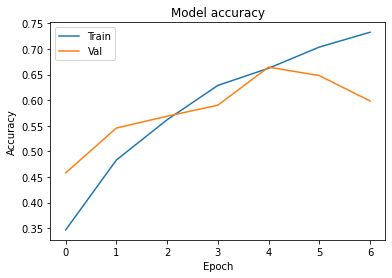

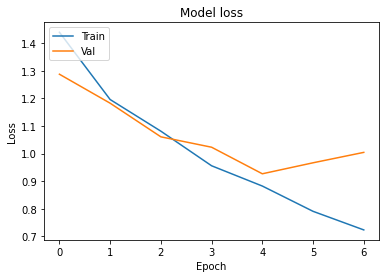

In [18]:
# plot training and validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc = 'upper left')
plt.show()

# plot training and validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc = 'upper left')
plt.show()

In [19]:
train_loss, train_acc = model.evaluate(X_train, Y_train)
test_loss, test_acc = model.evaluate(X_test, Y_test)
print("Accuracy on train set is %f" %(train_acc * 100)  + "%")
print("Accuracy on validation set is %f" %(test_acc * 100)  + "%")

41/41 [==============================] - 17s 415ms/step - loss: 0.9640 - accuracy: 0.6196
Accuracy on train set is 66.236347%
Accuracy on validation set is 61.959875%


Как мы видим, Accuracy = 66.2% для тренировочных данных и 61.9% для валидирующих. Мы могли бы получить результат намного лучше, если бы сделали больше чем 7 эпох, но так как возможность google collab ограничены, было решено сделать именно 7.